<a href="https://colab.research.google.com/github/ghozzza/machine-learning-dicoding/blob/main/submission_deployment_(7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [ ]:
import os
os.listdir('drive/MyDrive/submission-deployment')

['fail', 'TEST', 'TRAIN']

In [ ]:
TRAINING_DIR = "drive/MyDrive/submission-deployment/Train"
VALIDATION_DIR = "drive/MyDrive/submission-deployment/Valid"

print("Hello World")
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    batch_size=256,
                                                    target_size=(150, 150))

FileNotFoundError: ignored

In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        batch_size=256,
                                                        target_size=(150, 150))

Found 1507 images belonging to 3 classes.


In [ ]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2

In [ ]:
model = tf.keras.models.Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 32)          368672    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 32)          0         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 256)               8

In [ ]:
int_lr = 1e-4
num_epochs = 10

optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAccuracy has reached >90%!")
      self.model.stop_training = True



In [ ]:
callbacks = myCallback()

In [ ]:
H = model.fit(train_generator, epochs=num_epochs, callbacks=[callbacks], validation_data=validation_generator)

Epoch 1/10
24/24 [==============================] - 53s 2s/step - loss: 0.0904 - accuracy: 0.9719 - val_loss: 1.3890 - val_accuracy: 0.7717
Epoch 2/10
24/24 [==============================] - 49s 2s/step - loss: 0.0840 - accuracy: 0.9717 - val_loss: 1.3055 - val_accuracy: 0.7737
Epoch 3/10
24/24 [==============================] - 47s 2s/step - loss: 0.0686 - accuracy: 0.9759 - val_loss: 1.1948 - val_accuracy: 0.7989
Epoch 4/10
24/24 [==============================] - 47s 2s/step - loss: 0.0653 - accuracy: 0.9779 - val_loss: 1.1494 - val_accuracy: 0.8155
Epoch 5/10
24/24 [==============================] - 48s 2s/step - loss: 0.0738 - accuracy: 0.9735 - val_loss: 1.1772 - val_accuracy: 0.8056
Epoch 6/10
24/24 [==============================] - 47s 2s/step - loss: 0.0578 - accuracy: 0.9795 - val_loss: 1.0094 - val_accuracy: 0.8235
Epoch 7/10
24/24 [==============================] - 49s 2s/step - loss: 0.0744 - accuracy: 0.9775 - val_loss: 1.0845 - val_accuracy: 0.8096
Epoch 8/10
24/24 [==

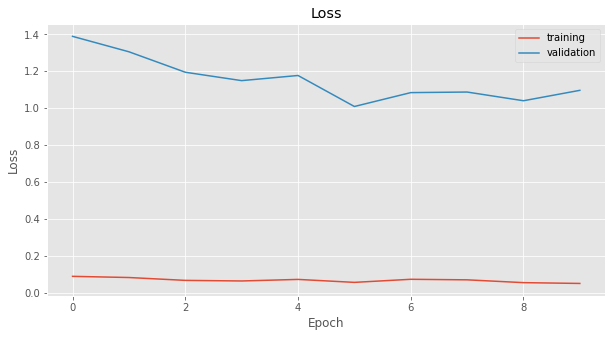

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

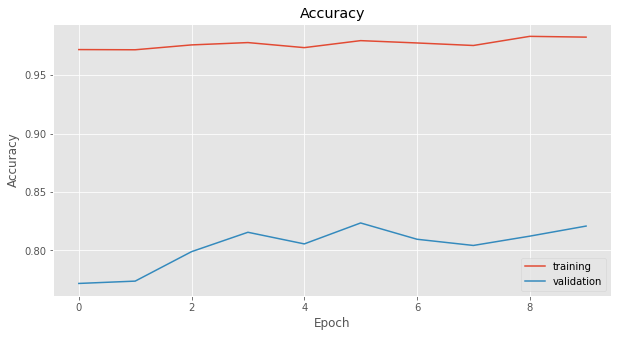

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)


10493364